# TP : Maximum entropy principle and Langevin algorithm
Main author: [Valentin De Bortoli](https://vdeborto.github.io/)

Edits by [Bruno Galerne](https://www.idpoisson.fr/galerne/)
   
   ## Summary  
   1. [Maximum entropy estimation with Stochastic Optimization with Unadjusted Langevin (SOUL)](#SOUL)  
       1.1 [The Simplest Neural Network](#simplest_nn)  
       1.2 [Stochastic Optimization with Unadjusted Langevin (SOUL)](#inverse)  

We will need the following packages.

In [6]:
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt
import torch
from scipy.linalg import sqrtm
from sklearn import datasets
from tqdm import tqdm
from draw_functions import *

In [7]:
class Gaussian_2D:

    def __init__(self, mu, cov):
        self.mu = mu
        self.cov = cov
        self.prec = np.linalg.inv(cov)

    def fun(self, x):
        mu = self.mu
        cov = self.cov
        prec = self.prec

        x_shift = x - mu
        val = np.linalg.det(2 * np.pi * cov) ** (-1 / 2)
        val = val * np.exp(- np.dot(x_shift, np.dot(prec, x_shift)) / 2)
        return val

    def grad(self, x):
        mu = self.mu
        prec = self.prec
        x_shift = x - mu
        val = - self.fun(x) * np.dot(prec, x_shift)
        return val


class Mixture_Gaussian_2D:

    def __init__(self, mu_list, cov_list, w_list):
        self.mu_list = mu_list
        self.cov_list = cov_list
        self.w_list = w_list
        self.prec_list = [np.linalg.inv(cov) for cov in cov_list]
        self.gaussian_list = [Gaussian_2D(*m) for m in zip(mu_list, cov_list)]

    def fun(self, x):
        val = 0
        for w, gauss in zip(self.w_list, self.gaussian_list):
            val += w * gauss.fun(x)
        return val

    def log_likelihood_fun(self, x):
        return np.log(self.fun(x))

    def log_likelihood_grad(self, x):
        val = 0
        for w, gauss in zip(self.w_list, self.gaussian_list):
            val += w * gauss.grad(x)
        val = val / self.fun(x)
        return val

    def sample(self, Ndata):
        mu = self.mu_list
        cov = self.cov_list
        w = self.w_list

        x = np.zeros((Ndata, 2))
        z = np.random.randn(Ndata, 2)
        ncomp = len(w)
        idx_arr = np.random.choice(ncomp, Ndata, p=w)
        k = 0
        for idx in idx_arr:
            x[k, :] = mu[idx] + np.dot(sqrtm(cov[idx]), z[k, :])
            k += 1
        return x

## Maximum entropy estimation
<a id="SOUL"></a>

In the previous section, we supposed that we knew the density of the model we tried to produce samples from this model. Now, we consider the reverse problem. We assume that we have access to a fix number of samples of the model (this number can be equal to one! See the texture synthesis application) and we try to find a good model which fits the data.

Therefore, our task can be divided into two parts:
- finding suitable models to describe the data,
- given a model and the data, provide an algorithm to find the "best" model according to the data.

First, we describe a simple (one-layer) neural network which can describes toy datasets. 
Then, we turn to the implementation of the Stochastic Optimization with Unadjusted Langevin (SOUL) algorithm.

### The Simplest Neural Network
<a id="simplest_nn"></a>

Suppose we are given a dataset $\mathcal{X} \in \mathbb{R}^{N \times d}$ where $N$ is the number of samples and $d$ their dimension. Let $a \in \mathbb{R}^d$ and $b \in \mathbb{R}$. We consider the following approximation
\begin{equation}
\mathbb{E}[f_{a,b}(X)] \simeq N^{-1} \sum_{j=1}^N f_{a,b}(\mathcal{X}_j) \; ,
\end{equation}
where $f_{a,b}: \ \mathbb{R}^d \to [0, +\infty)$ is given for any $x \in \mathbb{R}^d$ by 
\begin{equation}
f_{a,b}(x) = (\langle a, x \rangle + b)_+ \; .
\end{equation}
We assume that we have access to $p$ functions $(f_{a_i,b_i})_{i \in \{1, \dots, p\}}$.
Our goal is to find the model (distribution over $\mathbb{R}^d$, $\pi$) which has maximum entropy given the following constraints. For any $i \in \{1, \dots, p\}$, we have
\begin{equation}
\int_{\mathbb{R}^d} f_{a_i, b_i}(x) \mathrm{d} \pi(x) = N^{-1} \sum_{j=1}^N f_{a_i,b_i}(\mathcal{X}_j) \; .
\end{equation}
For simplicity, in this lab-session $(a_i)_{i \in \{1, \dots, p\}}$ are (fixed) realizations of a $d$-dimensional Gaussian random variable with zero mean and identity covariance. Similarly $(b_i)_{i \in \{1, \dots, p\}}$ are (fixed) realizations of a univariate Gaussian random variable with zero mean and identity covariance. The two random variables are supposed to be independent. Let us first describe the features we consider.

In [8]:
class feature():
    def __init__(self, N, data, activation='relu'):
        d = data.shape[-1]
        feature.activation = activation
        feature.d = d
        feature.N = N
        alpha, beta = self.random(N)
        feature.alpha = alpha
        feature.beta = beta

        target = self.montecarlo(data)
        feature.target = target

    def random(self, N):
        d = self.d
        alpha = np.random.randn(N, 1, d)
        beta = np.random.randn(N, 1)
        return alpha, beta

    def eval(self, x):
        alpha = self.alpha
        beta = self.beta

        out = np.sum(alpha * x, -1) + beta
        if self.activation == 'relu':
            out = out * (out > 0)
        elif self.activation == 'abs':
            out = np.abs(out)
        return out

    def grad(self, x):
        alpha = self.alpha
        beta = self.beta

        out = np.sum(alpha * x, -1) + beta
        if self.activation == 'relu':
            out = out > 0
        elif self.activation == 'abs':
            out = np.sign(out)
        out = out.reshape(out.shape + (1,))
        out = out * alpha
        return out

    def montecarlo(self, data):
        out = self.eval(data)
        out = np.mean(out, 1)
        out = out.reshape(out.shape + (1,))
        return out

**Questions:**
1. What is computed in feature.target?
2. What is computed by the feature.grad function?

We recall the maximum entropy problem. Given a reference probability measure $\mu$ and a function $F: \ \mathbb{R}^d \to \mathbb{R}^p$ we want to find (if it exists) a probability measure $\pi$ which solves the following problem
\begin{equation}
\min_{\pi \in \mathcal{P}_{\alpha, F}} \mathrm{KL}(\pi | \mu) \; ,
\end{equation}
where $\mathcal{P}_{\alpha, F} = \{ \pi \in \mathcal{P}_{\alpha}, \ \int_{\mathbb{R}^d} F(x) \mathrm{d}\pi(x) = 0 \}$, $\mathcal{P}_{\alpha} = \{ \pi \in \mathcal{M}(\mathbb{R}^d), \ \int_{\mathbb{R}^{d}} \| x \|^{\alpha} \mathrm{d} x < +\infty \}$ and $\mathcal{M}(\mathbb{R}^d)$ is the set of probability measures over $\mathbb{R}^d$.
In addition, $\sup_{x \in \mathbb{R}^d} \left\lbrace \| F(x) \| (1+ \| x \|)^{-\alpha} \right\rbrace < +\infty$. Under suitable conditions on the measure $\mu$ and the function $F$ we obtain that the solution of this minimization problem exists, is unique and is given for any $x \in \mathbb{R}^d$ by 
\begin{equation}
(\mathrm{d} \pi_{\theta^{\star}} / \mathrm{d} \mu)(x) = \exp[- \langle \theta^{\star}, F(x) \rangle] \; ,
\end{equation}
where $\theta^{\star}$ is the solution of the following convex problem.
\begin{equation}
\min_{\theta \in \Theta} L(\theta) \; .
\end{equation}
where $\Theta = \{ \theta \in \mathbb{R}^p, \ \int_{\mathbb{R}^{d}} \exp[- \langle \theta, F(x) \rangle ] \mathrm{d} \mu(x) < +\infty$ and $L(\theta)$ is the log-partition function given for any $\theta \in \Theta$ by 
\begin{equation}
L(\theta) = \int_{\mathbb{R}^d} \exp[-\langle \theta, F(x) \rangle] \mathrm{d} \mu (x) \; .
\end{equation}

In our running example, we will consider $F = (f_{a_i, b_i} - c_i)_{i \in \{1, \dots, p\}}$ where the $c_i$ are the target statistics
\begin{equation}
c_i = \frac{1}{N}\sum_{j=1}^N f_{a_i,b_i}(\mathcal{X}_j) \; .
\end{equation}
We will take the reference measure to be a Gaussian distribution with zero mean and diagonal covariance with entries given by $\sigma^2$ with $\sigma$ large.

### Stochastic Optimization with Unadjusted Langevin
<a id="inverse"></a>

We now assume that $\mu$ admits a Radon-Nikodym derivative with respect to the Lebesgue measure, and denote $r: \ \mathbb{R}^d \to \mathbb{R}$ such that for any $x \in \mathbb{R}^d$, 
\begin{equation}
(\mathrm{d} \mu / \mathrm{d} \mathrm{Leb})(x) = \exp[-r(x)] \; .
\end{equation}
In our running example, we have $r(x) = \| x \|^2/ (2 \sigma^2)$.
In this case, the Stochastic Optimization with Unadjusted Langevin (SOUL) algorithm aims at finding the optimal parameters $\theta^{\star}$ by performing a stochastic gradient on $L$, whose gradient is approximated by a Monte Carlo average.

In [9]:
def soul(params):
    d = params['d']
    delta = params['delta']
    gamma = params['gamma']
    m = params['m']
    Nit = params['Nit']
    stride = params['stride']
    target = params['target']
    fun = params['fun']
    grad = params['grad']
    init_theta = params['init_theta']
    init_x = params['init_x']
    sigma = params['sigma']

    x_list = []
    theta_list = []

    x = init_x
    theta = np.reshape(init_theta, (init_theta.shape + (1,)))
    target = np.reshape(target, (target.shape + (1,)))

    for n in tqdm(range(Nit)):
        if n % stride == 0:
            x_list.append(x)
            theta_list.append(theta)
        feat_avg = 0
        for k in range(m):
            noise = np.random.randn(d)
            update = np.sum(np.sum(theta * grad(x), 0), 0)
            update = update - sigma ** (-2) * x
            x = x - gamma * update + np.sqrt(2 * gamma) * noise
            feat_avg = (k * feat_avg + fun(x)) / (k + 1)

        feat_avg = np.reshape(feat_avg, (feat_avg.shape + (1,)))
        theta = theta + delta * (feat_avg - target)

    x_arr = np.array(x_list)
    theta_arr = np.array(theta_list)
    theta_arr = theta_arr.squeeze()
    return x_arr, theta_arr

The following function generates a dataset from a 2D GMM which will be used to perform the estimation.

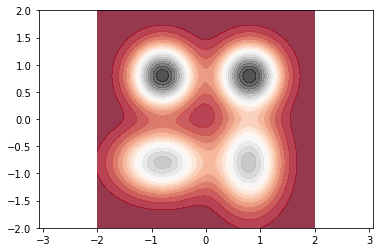

In [19]:
# 2D GMM densityfor for sampling data
dil = 0.8
sigma_sq = 0.15
mu_list = [np.array([-dil, -dil]), np.array([dil, -dil]),
           np.array([-dil, dil]), np.array([dil, dil])]
cov_list = []
cov_list.append(sigma_sq * np.array([[2, 0], [0, 1]]))
cov_list.append(sigma_sq * np.array([[1, 0], [0, 2]]))
cov_list.append(sigma_sq * np.array([[1, 0], [0, 1]]))
cov_list.append(sigma_sq * np.array([[1, 0], [0, 1]]))
w_list = [1 / 4, 1 / 4, 1 / 4, 1 / 4] #[1 / 8, 1 / 2, 1 / 8, 1 / 4]
gmm2d = Mixture_Gaussian_2D(mu_list, cov_list, w_list)

# View 2D GMM density
fig, ax = plt.subplots(1,1)
draw_density(gmm2d, ax)

Ns = 2*10 ** 5
p = 10 ** 2

# 
f = feature(p, gmm2d.sample(Ns), activation = 'relu')

params = {'d': 2,
          'sigma': 10,
          'delta': 10 ** -2,
          'gamma': 10 ** -2,
          'm': 10 ** 2,
          'Nit': 10 ** 4,
          'stride': 10 ** 1,
          'target': f.target,
          'fun': f.eval,
          'grad': f.grad,
          'init_x': np.array([0, 0]),
          'init_theta': f.eval(np.array([0, 0])) * 0}

We now apply the SOUL algorithm.

In [20]:
x_arr, theta_arr = soul(params)

100%|██████████| 10000/10000 [00:59<00:00, 168.73it/s]


First, let us observe the output samples.

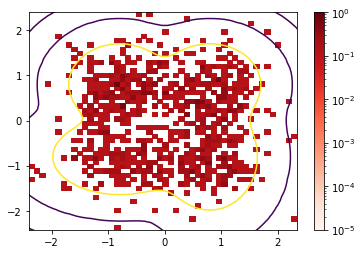

In [12]:
draw_estimated_density(x_arr, gmm2d)

Now, let us take a look at the estimated parameters.

/home/galerne/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


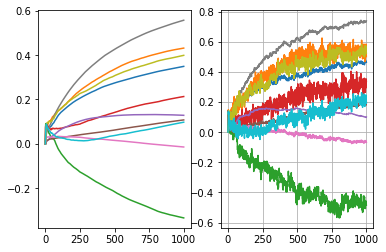

In [13]:
draw_theta(theta_arr)

Obvsiouly, we only have an approximation of the mixture of Gaussians.
It is interesting to visualize the density we obtain. Notice that the contours of the density are segments which is coherent with our features which have different behavior depending on the half-space.

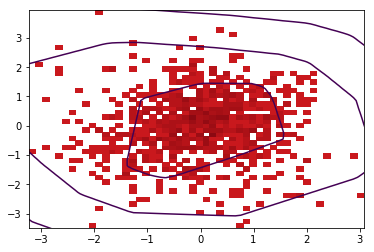

In [21]:
draw_learn_density(f, x_arr, theta_arr)

**Questions:**
Adapt the function draw_learn_density (code reproduced below) into draw_learn_density_select and check that the mean of the 20 last theta values provide an exponential model that is better adpated than the mean of the 20 theta values starting at BURNIN.

In [15]:
def draw_learn_density_select(model, x_arr, theta_arr):
    BURNIN = 10 ** 2
    NBINS = 50
    vmin = 10 ** -5
    vmax = 1
    x1 = x_arr[BURNIN:, 0].view()
    x2 = x_arr[BURNIN:, 1].view()
    plt.hist2d(x1, x2, bins=NBINS, cmap=plt.cm.Reds,
               normed=True, norm=colors.LogNorm(vmin, vmax))

    RANGE = 5
    axis = np.linspace(-RANGE, RANGE, 10 ** 2)
    X, Y = np.meshgrid(axis, axis)
    xy = np.vstack([Y.ravel(), X.ravel()]).T

    theta_arr_m = theta_arr[BURNIN:, :]
    theta_arr_m = np.mean(theta_arr_m, 0)
    out = density_model(model, theta_arr_m, xy)
    out = out.reshape(X.shape)
    contour_disc = np.flip(np.exp(-np.linspace(0, 5, 10 ** 1) ** 2))
    plt.contour(X, Y, out, contour_disc)

    plt.show()